# Superdense Coding

In this notebook, we will implement superdense coding in qiskit.

In [121]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# For nice graphics
%config InlineBackend.figure_format = 'svg'

The basic premise is that Alice wants to send a message to Bob, and a third agent Charlie prepares the initial qubit superposition for them. Bob gets Alice's qubit everytime she sends a message, whereas Alice need not have direct access to Bob's qubit.

In [122]:
# Charlie's qubits
def create_bell_pair(qc : QuantumCircuit, a : int, b : int):
    """
    Takes a 2-qubit quantum circuit and creates a bell state out of `a` and `b` qu-bits.
    """
    qc.h(a)
    qc.cx(a, b)


In [123]:
def send_message(message : int, qc : QuantumCircuit, alice_qubit : QuantumRegister):
    """
    Prepares qc to send the message, where alice_qubit is Alice's QuantumRegister.
    """
    if(message % 2 == 1):
        qc.x(alice_qubit)
    if(message / 2 == 1):
        qc.z(alice_qubit)

In [124]:
def receive_message(qc : QuantumCircuit, alice_qubit : QuantumRegister, bob_qubit : QuantumRegister):
    qc.cx(alice_qubit, bob_qubit)
    qc.h(alice_qubit)

In [125]:
# Change this message to be any 2-bit message
message = 0b01

In [126]:
# This is where it all comes together

alice_qubit = QuantumRegister(1, 'alice')
bob_qubit = QuantumRegister(1, 'bob')

circuit = QuantumCircuit(alice_qubit, bob_qubit)

create_bell_pair(circuit, 0, 1)
circuit.barrier()
send_message(message, circuit, alice_qubit)
circuit.barrier()
receive_message(circuit, alice_qubit, bob_qubit)
circuit.barrier()

received_message = ClassicalRegister(2, 'message')
circuit.add_register(received_message)

circuit.measure(alice_qubit, received_message[0])
circuit.measure(bob_qubit, received_message[1])

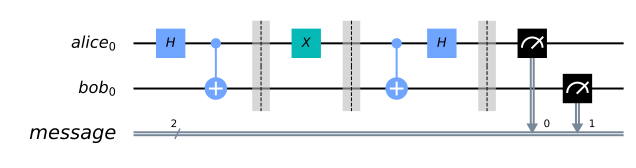

In [127]:
circuit.draw("mpl")


In [128]:
def run_circuit_simulator(qc : QuantumCircuit):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024)
    return job

In [137]:
# This assumes you already have IBMQ account loaded through the key

# IBMQ.load_account()

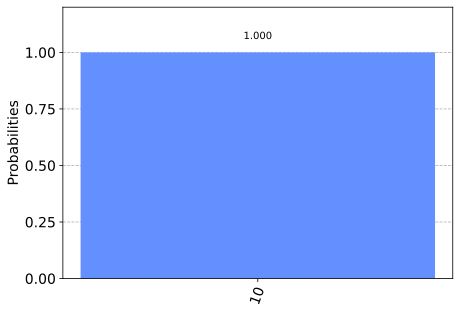

In [131]:
job = run_circuit_simulator(circuit)

plot_histogram(job.result().get_counts())

In [133]:
def run_circuit_ibm(qc : QuantumCircuit):
    provider = IBMQ.get_provider('ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: 
                                                x.configuration().n_qubits >= 2 
                                                and not x.configuration().simulator 
                                                and x.status().operational==True))
    print("Running our job on: ", backend)
    job = execute(qc, backend=backend, shots=1024)
    return job

Running our job on:  ibmqx2
Job Status: job has successfully run


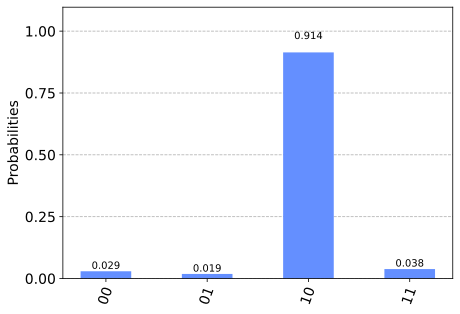

In [134]:
# Run this to execute the circuit on an actual quantum computer from IBM
job = run_circuit_ibm(circuit)
job_monitor(job)
counts = job.result().get_counts()

plot_histogram(counts)

Any deviations you see from actual result is because of errors in performing gate operations due to noise. Fixing that is the physicist's problem :-)

In [138]:
from qiskit import __qiskit_version__
__qiskit_version__

{'qiskit-terra': '0.14.1',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.1',
 'qiskit': '0.19.3'}